## Connecting gDrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


# Introduction and Data Description

The goal of this project is to predict which of the provided pairs of questions have the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

Please note: as an anti-cheating measure, Kaggle supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora.

### Data Fields

* id - the id of a training set question pair
* qid1, qid2 - unique ids of each question (only available in train.csv)
* question1, question2 - the full text of each question
* is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [1]:
# Loading the required libraries

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# loading the data from drive in pandas dataframe

train = pd.read_csv('/content/gdrive/My Drive/datasets/quora/train.csv')

# Exploratory Data Analysis

In [ ]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB




---


* Number of rows(Training question pairs) = 404290
* There are two NULL values in 'question2' column and one NULL value in 'question1' column.

---



0    255027
1    149263
Name: is_duplicate, dtype: int64


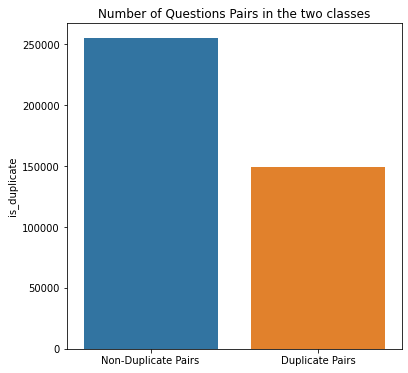

In [13]:
# Distribution of the output classes

print(train['is_duplicate'].value_counts())
plt.figure(figsize=(6,6))
plt.title('Number of Questions Pairs in the two classes')
sns.barplot(['Non-Duplicate Pairs', 'Duplicate Pairs'], train['is_duplicate'].value_counts())
plt.show()

In [19]:
# Number of unique questions in the entire dataset

ques = list(train['qid1']) + list(train['qid2'])
number_of_unique = len(np.unique(ques))
print('Number of Unique Questions = {} \nOut of total of {} questions'.format(number_of_unique, len(ques)))

Number of Unique Questions = 537933 
Out of total of 808580 questions


In [5]:
# Number of questions appearing once and number of questions repeating

qid_frequency = pd.Series(ques).value_counts()

False    426153
True     382427
dtype: int64


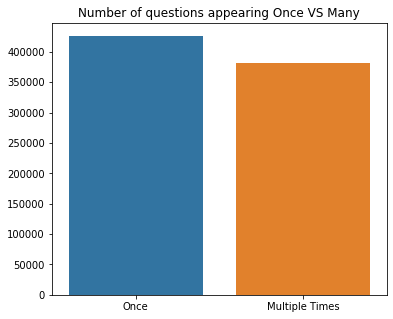

In [41]:
# 'True' value which have duplicates and 'False' which appeared only once
count_many_once = pd.Series(ques).duplicated(keep=False).value_counts()
print(count_many_once)

plt.figure(figsize=(6,5))
plt.title('Number of questions appearing Once VS Many')
sns.barplot(['Once','Multiple Times'], count_many_once)
plt.show()

In [ ]:
# Duplicate Rows Check

duplicate_pairs = train[train.duplicated(subset=['qid1','qid2'])]
print('Number of duplicate question pairs =',len(duplicate_pairs))

Number of duplicate question pairs = 0


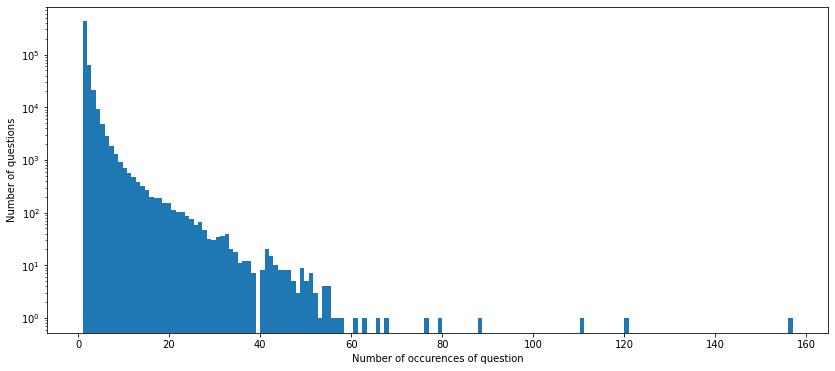

In [22]:
# Histogram of Occurence of each question

plt.figure(figsize=(14,6))
plt.hist(qid_frequency, bins = 160)
plt.yscale('log')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()